# TP 3 : Optimal Execution and Market Making

### Louis-Marie Lovichi - Thomas Seror - Elie Jabbour - Elias Moussa

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

## I. Optimal split of orders across liquidity pools

### 1) Outils

On écrit ici deux algorithmes nécessaires pour la suite du TP :

- Algorithme de projection sur le simplexe.
- Algorithme de pré-processing des données.

In [48]:
def projection_simplexe(v, z=1):
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    rho = np.nonzero(u * np.arange(1, n+1) > cssv)[0][-1]
    theta = cssv[rho] / (rho + 1.0)
    w = np.maximum(v - theta, 0)
    return w

In [49]:
def get_data(data_folder_path, assets):

    if not os.path.exists(data_folder_path):
        print("Le dossier n'est pas trouvable à l'adresse suivante", data_folder_path)

    else:
        
        dico_data = {asset: None for asset in assets}

        for filename in os.listdir(data_folder_path):
            if filename[:-3] in dico_data:
                file_path = os.path.join(data_folder_path, filename)
                dico_data[filename[:-3]] = pd.read_hdf(file_path)
    
    return dico_data

### 2) Experiments

In [51]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
data_folder_path = os.path.join(parent_directory, 'Stock Data') # nom du dossier contenant les données à la racine.

assets = ['BOUYGUES', 'LVMH', 'SANOFI', 'TOTAL']

dico_data = get_data(data_folder_path, assets)

In [52]:
# classe objet permettant de récupérer les données sur une liste donnée en entrée.

class Equities():


    def __init__(self, 
                 assets: list[str], 
                 dico_data: dict) -> None:
        
        self.assets = assets
        self.dico_data = dico_data


    def compute_prices_volumes(self, 
                               T: int, 
                               year: int=2011,
                               month: int=12,
                               day: int=5,
                               nb_day = 12) -> tuple[dict, dict]:

        dico_prices = {}
        dico_volumes = {}
        date_debut = pd.Timestamp(year=year, month=month, day=day, hour=9)
        date_fin = date_debut + pd.Timedelta(days=nb_day)
        
        index_df = []

        for asset in self.assets:

            df = dico_data[asset].resample(f'{T}min').mean()
            df = df[df['TradedQty']>0]
            df = df.loc[(df.index >= date_debut) & (df.index <= date_fin)]
            dico_prices[asset] = df['TradedPrice']
            index_df.append(df.index)

            df = dico_data[asset].resample(f'{T}min').sum()
            df = df[df['TradedQty']>0]
            df = df.loc[(df.index >= date_debut) & (df.index <= date_fin)]
            dico_volumes[asset] = df['TradedQty']
            index_df.append(df.index)
        
        intersect_df = index_df[0]
        for i in range(1, len(index_df)):
            intersect_df = intersect_df.intersection(index_df[i])
        
        for (key, value) in dico_prices.items():
            dico_prices[key] = value.loc[intersect_df]
        for (key, value) in dico_volumes.items():
            dico_volumes[key] = value.loc[intersect_df]

        return dico_prices, dico_volumes

On récupère les données associées aux assets qui nous intéressent sur une certaine plage de temps.

In [53]:
T = 1
equities = Equities(assets, dico_data)
dico_prices, dico_volumes = equities.compute_prices_volumes(T, nb_day=30)

In [54]:
# classe objet permettant de créer un DarkPool pour un asset particulier, traded_asset en prenant une liste d'assets en référence, assets.

class DarkPool: 

    def __init__(self, 
                 traded_asset: str, 
                 assets: list[str],
                 alpha: np.array,
                 beta: np.array,
                 rho: np.array) -> None:
        
        self.beta = beta
        self.alpha = alpha
        self.rho = rho
        self.traded_asset = traded_asset

        reference_assets = assets.copy()
        reference_assets.remove(traded_asset)
        self.reference_assets = reference_assets
        self.dico_darkpools = None


    def create_darkpools(self, 
                         dico_prices: dict,
                         dico_volumes: dict) -> None:
        
        dico_darkpools = {}

        traded_volume = dico_volumes[self.traded_asset]
        mean_traded_volume = traded_volume.mean()

        for (i, asset) in enumerate(self.reference_assets):

            alpha = self.alpha[i]
            beta = self.beta[i]

            price_asset = dico_prices[asset]
            mean_price_asset = price_asset.mean()

            darkpool = beta*((1-alpha)*traded_volume + alpha*price_asset*mean_traded_volume/mean_price_asset)

            dico_darkpools[asset] = darkpool

        self.dico_darkpools = dico_darkpools

    # allocation par algorithme stochastique
    def compute_stochastic_allocation(self,
                                      r0: np.array,
                                      c = 0.01) -> tuple[pd.DataFrame, np.array]:

        dates = dico_volumes[self.traded_asset].index
        traded_volume = dico_volumes[self.traded_asset]
        allocation = np.zeros((len(dates), len(self.reference_assets)))
        
        n = 1
        gamma = c/n

        for (j, date) in enumerate(dates):

            H = np.zeros(len(self.reference_assets))

            for (i, asset) in enumerate(self.reference_assets):
                
                if r0[i]*traded_volume[date] < self.dico_darkpools[asset][date]:
                    H[i] = self.rho[i]

            H -= np.mean(H)
            H *= traded_volume[date]
            r0 += gamma*H

            # mise à jour de gamma (gamma_n = 1/n)
            n += 1
            gamma = c/n
            
            allocation[j] = projection_simplexe(r0.copy())
        
        return dates, allocation
    
    # allocation look-ahead en benchmark
    def compute_oracle_allocation(self):
        
        dates = dico_volumes[self.traded_asset].index
        traded_volume = np.array(dico_volumes[self.traded_asset])

        allocation = np.zeros((len(dates), len(self.reference_assets)))

        indices_tries = sorted(range(len(self.rho)), key=lambda i: self.rho[i], reverse=True)
        remaining_quantity_to_allocate = np.ones(len(dates))
        for i in indices_tries:

            allocation[:, i] = np.minimum(remaining_quantity_to_allocate, np.array(self.dico_darkpools[self.reference_assets[i]])/traded_volume)
            remaining_quantity_to_allocate -= allocation[:, i]
        
        return dates, allocation

    # calcul du coût des trades
    def compute_cost(self, 
                     allocation: np.array) -> np.array:
        
        price_asset = dico_prices[self.traded_asset].astype(float)
        traded_volume = np.array(dico_volumes[self.traded_asset]).astype(float)
        cost = traded_volume.copy()

        for (i, asset) in enumerate(self.reference_assets):
            
            cost -= self.rho[i]*np.minimum(allocation[:, i]*traded_volume, np.array(self.dico_darkpools[asset]).astype(float))
            
        cost *= price_asset
        
        return cost

On crée alors le DarkPool associé.

In [55]:
alpha = np.array([0.4, 0.7, 0.5])
beta = np.array([0.2, 0.1, 0.15])
rho = np.array([0.03, 0.05, 0.02])

darkpool = DarkPool("TOTAL", assets, alpha, beta, rho)
darkpool.create_darkpools(dico_prices, dico_volumes)

On calcule les allocations.

In [56]:
r0 = np.ones(3)/3
dates, allocation_sto = darkpool.compute_stochastic_allocation(r0)

dates, allocation_oracle = darkpool.compute_oracle_allocation()

On calcule les coûts associées aux allocations.

In [57]:
cost_oracle = darkpool.compute_cost(allocation_oracle)
cost_sto = darkpool.compute_cost(allocation_sto)

no_darkpool_allocation = np.zeros(allocation_oracle.shape)
cost_no_darkpool = darkpool.compute_cost(no_darkpool_allocation)

On calcule les réductions de coût associées pour en calculer les performances.

In [58]:
CR_opti = (cost_no_darkpool-cost_sto)
CR_oracle = (cost_no_darkpool-cost_oracle)

performance = CR_opti/CR_oracle
performance

Time
2011-12-05 09:00:00    1.0
2011-12-05 09:01:00    1.0
2011-12-05 09:02:00    1.0
2011-12-05 09:03:00    1.0
2011-12-05 09:04:00    1.0
                      ... 
2011-12-30 17:25:00    1.0
2011-12-30 17:26:00    1.0
2011-12-30 17:27:00    1.0
2011-12-30 17:28:00    1.0
2011-12-30 17:29:00    1.0
Name: TradedPrice, Length: 6861, dtype: float64

On trace la moyenne mobile de la performance ainsi que les allocations au cours du temps.

In [59]:
nb_donnees_par_jour = int(8.5*60/T)

# calcul moyenne mobile
window_size = 100
y_ma = np.convolve(np.array(performance.values), np.ones(window_size)/window_size, mode='valid')

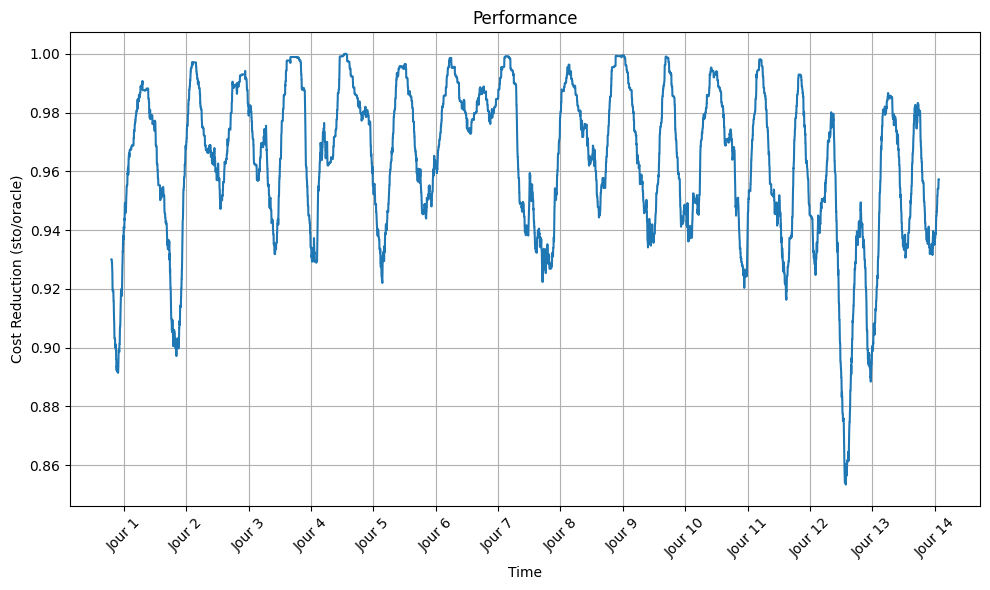

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(y_ma, linestyle='-')
plt.xlabel('Time')
plt.ylabel('Cost Reduction (sto/oracle)')
plt.title('Performance')

indices = np.arange(window_size, len(y_ma), nb_donnees_par_jour)
jours = [f'Jour {i//nb_donnees_par_jour + 1}' for i in indices]
plt.xticks(indices, jours, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

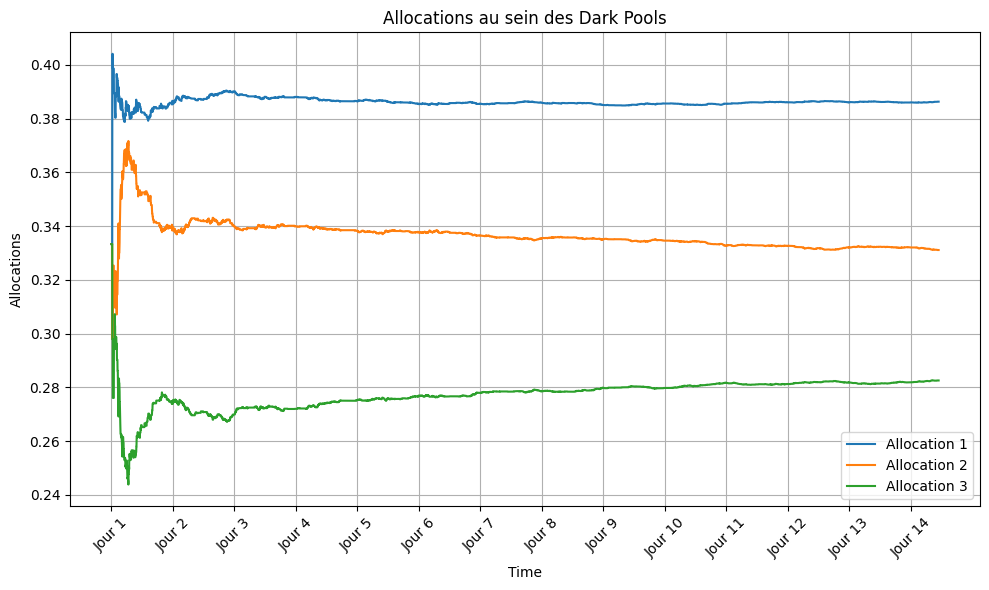

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(allocation_sto[:, 0], linestyle='-', label='Allocation 1')
plt.plot(allocation_sto[:, 1], linestyle='-', label='Allocation 2')
plt.plot(allocation_sto[:, 2], linestyle='-', label='Allocation 3')
plt.xlabel('Time')
plt.ylabel('Allocations')
plt.title('Allocations au sein des Dark Pools')

indices = np.arange(0, len(performance.values), nb_donnees_par_jour)
jours = [f'Jour {i//nb_donnees_par_jour + 1}' for i in indices]
plt.xticks(indices, jours, rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

En se plaçant dans une configuration « shortage », on observe que la convergence est très rapide. Par ailleurs, on peut formuler les remarques suivantes : 

- Très logiquement, l'allocation est plus importante pour les darkpools dont le discount est important à condition que le volume offert par le darkpool (piloté par $\beta$) est suffisante, on comprend donc naturellement les résultats obtenus.

- Les performances oscillent en moyenne entre 90 et 100 $\%$ par rapport à benchmark.

## II. Market Making

In [64]:
import seaborn as sns

%matplotlib inline

In [65]:
def import_data(file_path, start_date,num_day):
    df = pd.read_hdf(file_path, sep='\t', index_col='Time', parse_dates=True)
    date_debut = pd.to_datetime(start_date)
    date_fin = date_debut + pd.Timedelta(days=num_day)
    df =  df[(df.index >= date_debut) & (df.index <= date_fin)]

    return df 


def cost_of_execution_of_one_order(Di, ri, Tetai, S, V):
    N = len(Di)  # suppose que Di, ri et Tetai ont la même longueur
    sum_theta_min = sum(Tetai[i] * min(ri[i], Di[i]) for i in range(N))
    sum_rho_min = sum( min(ri[i], Di[i]) for i in range(N))

    C = S * sum_theta_min + S * (V - sum_rho_min)
    return C


def Hi(r, Di, rho, V):
    N = len(Di)  # suppose que Di et rho ont la même longueur
    indicator_sum = sum(rho[j] * (1 if r < Di[j] else 0) for j in range(N))

    return V * (rho[i] * (1 if r < Di[i] else 0) - (1/N) * indicator_sum)


Use the datasets on Paris Bourse: you have 4 assets (Bouygues, LVMH, Sanofi and Total). Select two weeks of data.


In [66]:
df_total = import_data('../Stock Data/TOTAL.h5', '2011-01-03', 1)
df_bouygues = import_data('../Stock Data/BOUYGUES.h5', '2011-01-03', 1)
df_lvmh = import_data('../Stock Data/LVMH.h5', '2011-01-03', 1)
df_sanofi = import_data("../Stock Data/SANOFI.h5",'2011-01-03', 1)


df_total

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign
Time,,,,,,,
2011-01-03 09:00:01.988,40.190,70,40.010,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.190,15,40.010,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.190,67,40.010,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.190,20,40.010,40.19,660800,40700,1
2011-01-03 09:00:01.988,40.190,250,40.010,40.19,660800,40700,1
...,...,...,...,...,...,...,...
2011-01-03 17:29:50.528,40.500,62,40.500,40.51,14500,144200,-1
2011-01-03 17:29:52.012,40.500,14,40.495,40.50,39100,16200,1
2011-01-03 17:29:52.012,40.500,148,40.495,40.50,39100,16200,1


### 1. Fillrates

In [67]:
def simulate_barrier_touch(df, d, t):
    """
    Simule le placement de barrières et enregistre chaque fois qu'elles sont touchées.
    
    :param df: DataFrame contenant les données de marché, indexé par DateTime.
    :param d: distance en ticks pour ajuster les barrières du bid et de l'ask.
    :param t: intervalle de temps en minutes pour réajuster les barrières.
    :return: DataFrame des résultats avec la date de mise en place, et le nombre de touches pour chaque barrière.
    """
    results = []
    last_update_time = df.index[0] - pd.Timedelta(minutes=t)  # Pour s'assurer de mettre à jour au premier pas
    
    # Initialisation des compteurs de touches
    bid_touches, ask_touches = 0, 0

    for current_time, row in df.iterrows():
        # Mise à jour des barrières tous les t minutes
        if (current_time - last_update_time) >= pd.Timedelta(minutes=t):
            if last_update_time != df.index[0] - pd.Timedelta(minutes=t):
                # Enregistrement des résultats de la période précédente
                results.append({'DateTime': last_update_time, 'BidTouches': bid_touches, 'AskTouches': ask_touches, 'spread': ask_barrier - bid_barrier -2*d})
            
            # Réinitialisation des compteurs de touches
            bid_touches, ask_touches = 0, 0
            last_update_time = current_time
            
            # Mise à jour des barrières
            bid_barrier = row['BidPrice'] - d
            ask_barrier = row['AskPrice'] + d
        
        # Vérification si les barrières sont touchées : à checker 
        if row['TradedPrice'] <= bid_barrier:
            bid_touches += 1
        if row['TradedPrice'] >= ask_barrier:
            ask_touches += 1
    
    # Enregistrement des résultats de la dernière période
    results.append({'DateTime': last_update_time, 'BidTouches': bid_touches, 'AskTouches': ask_touches, 'spread': ask_barrier - bid_barrier -2*d})
    
    return pd.DataFrame(results)

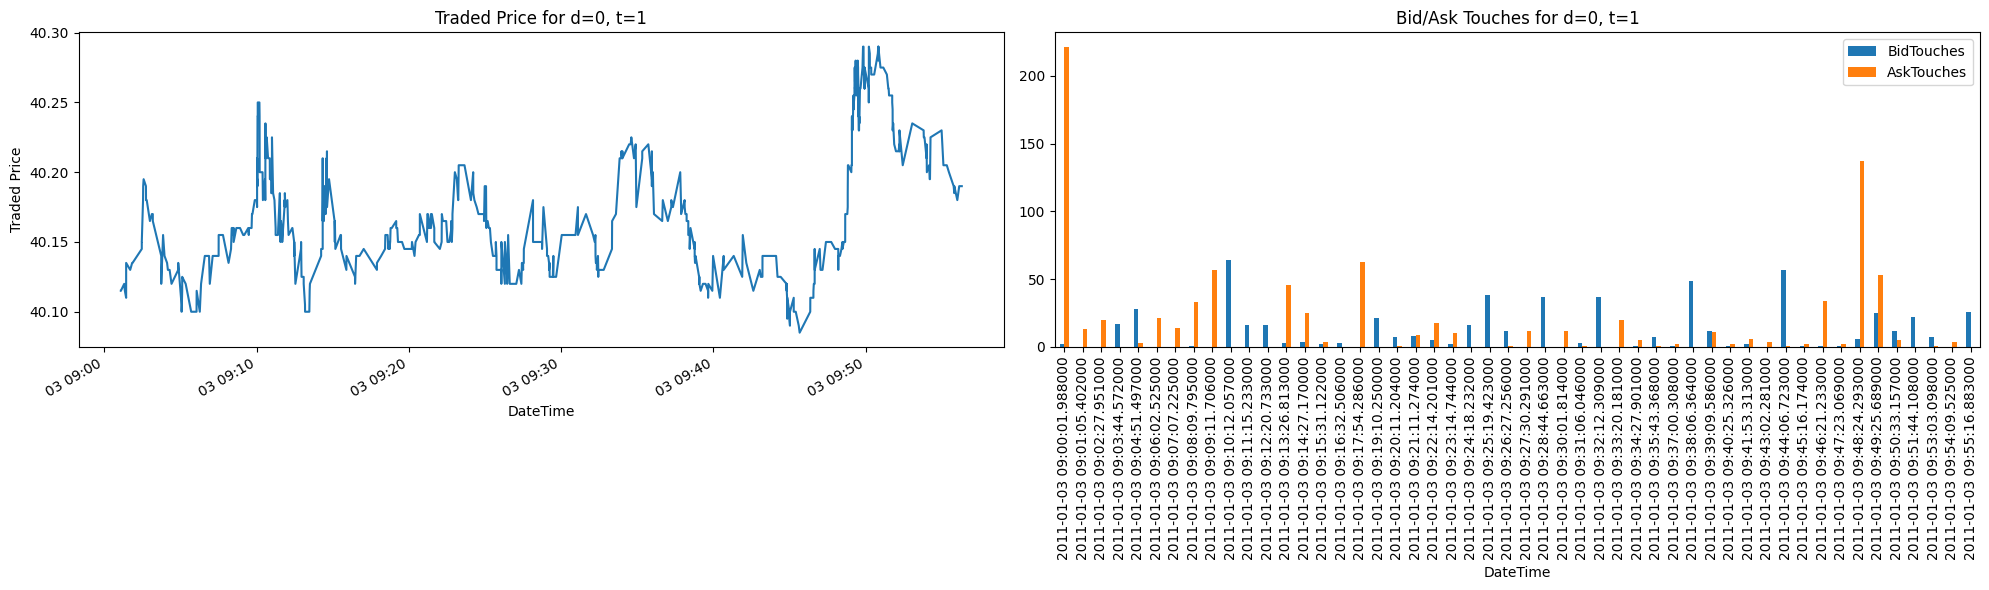

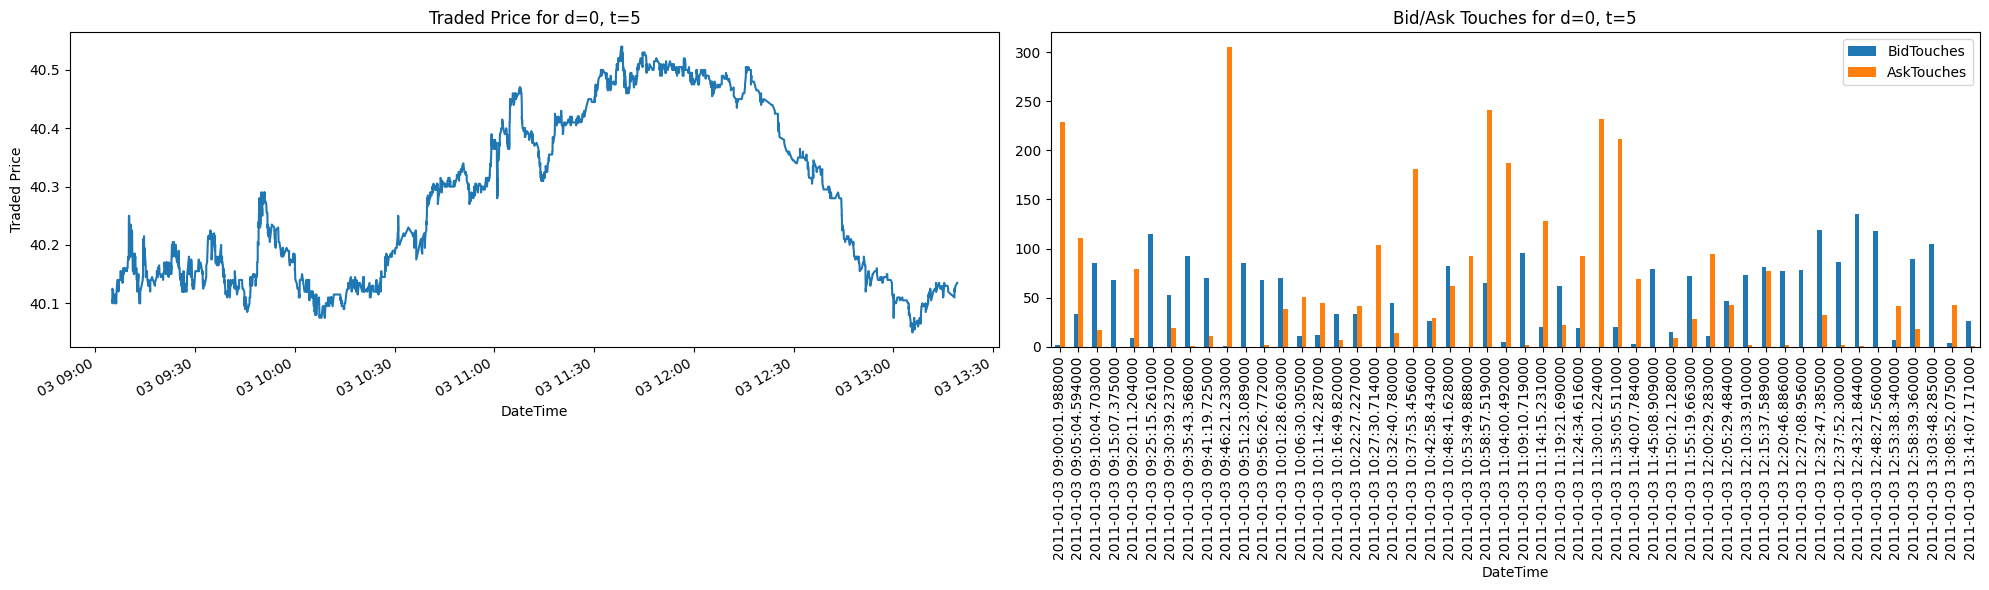

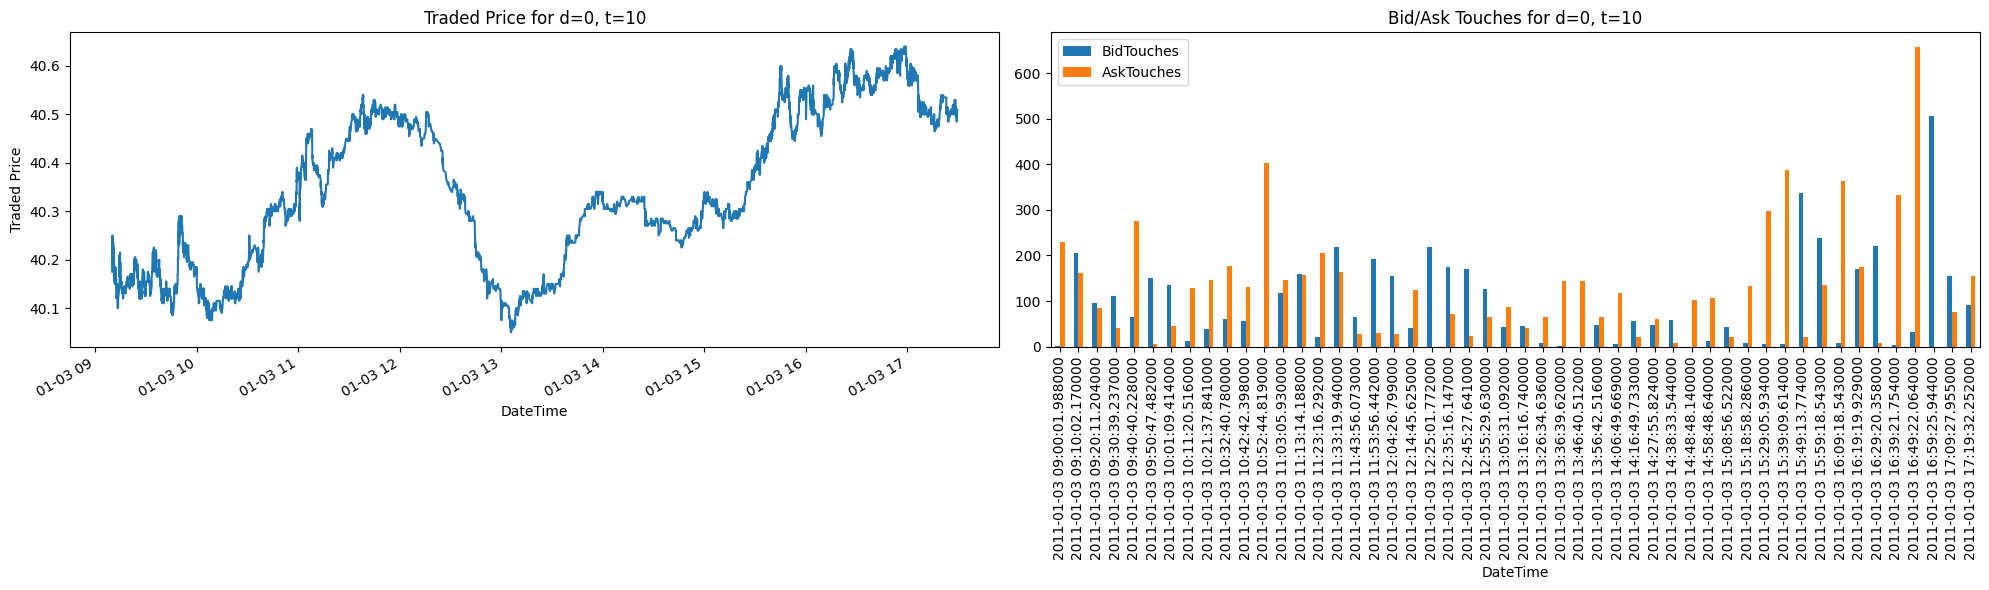

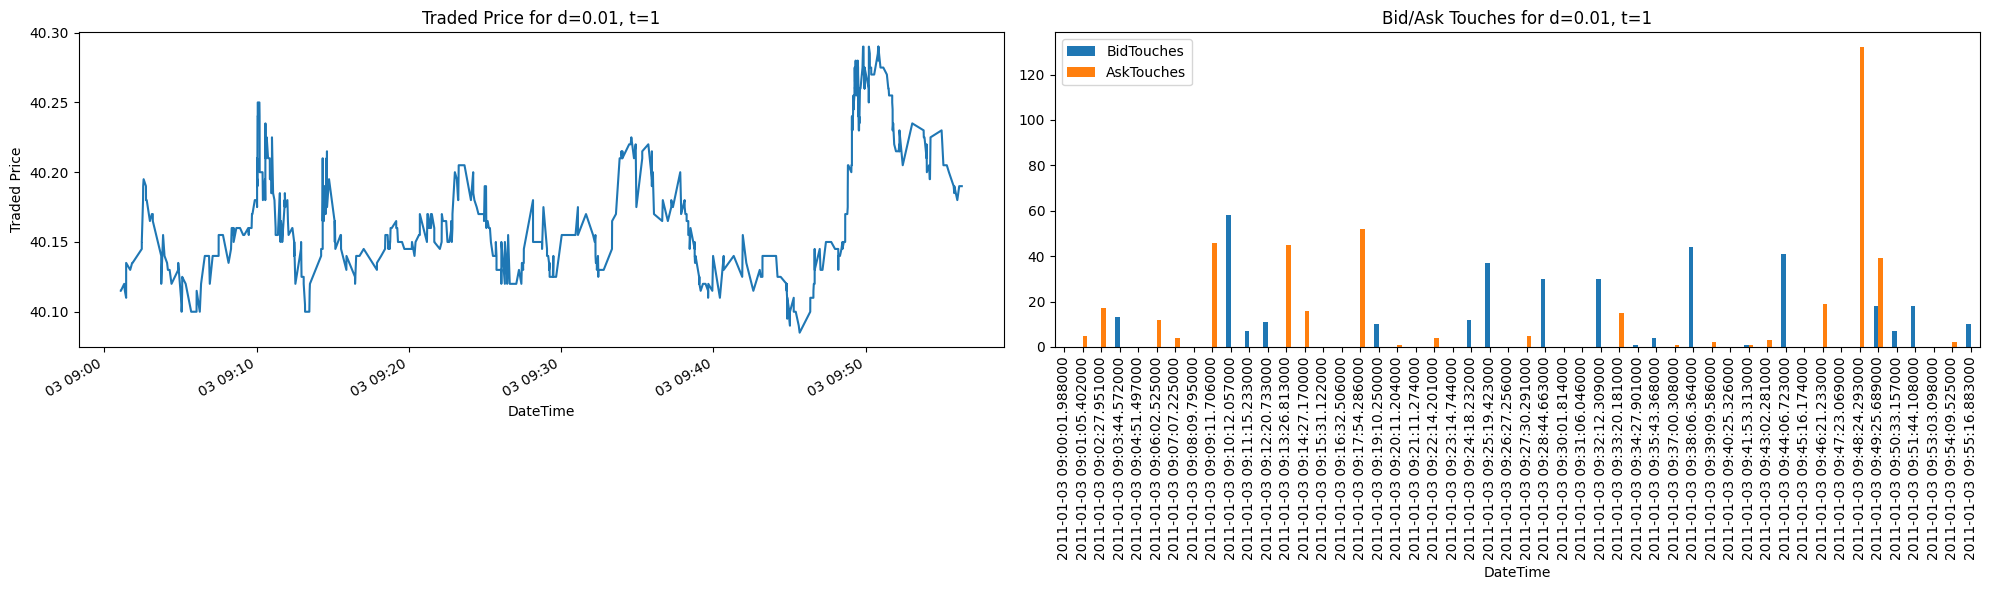

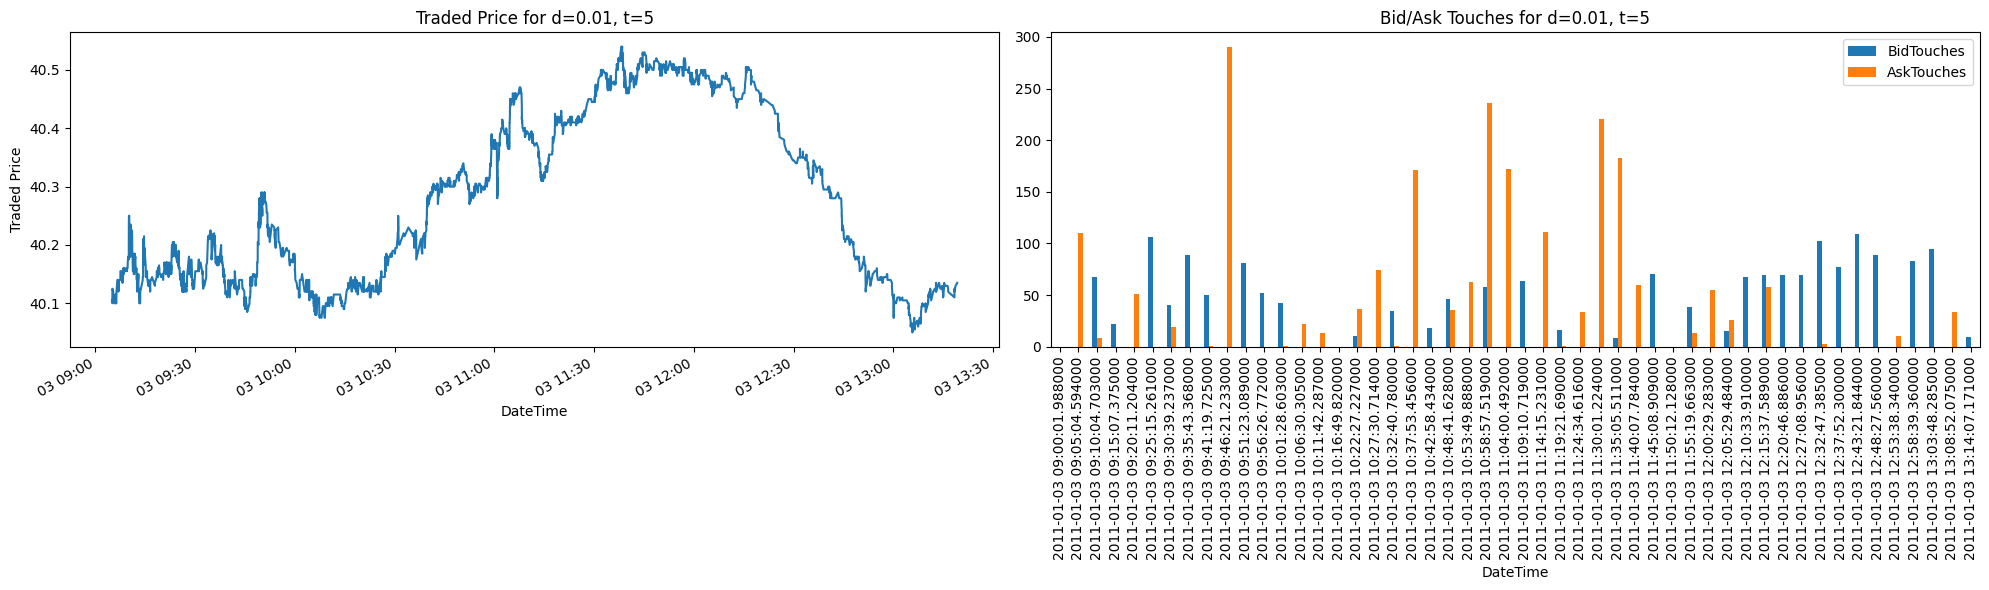

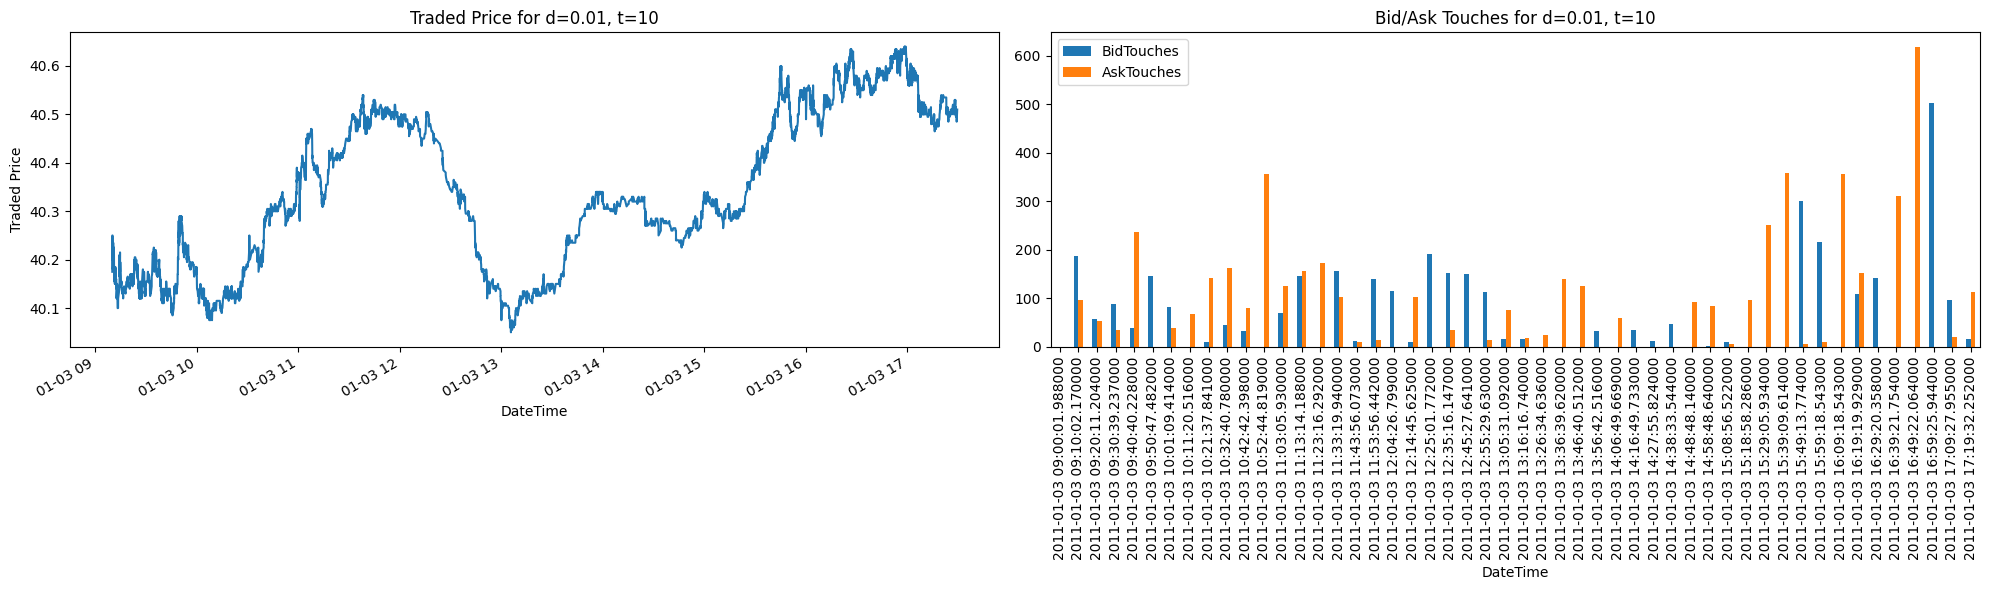

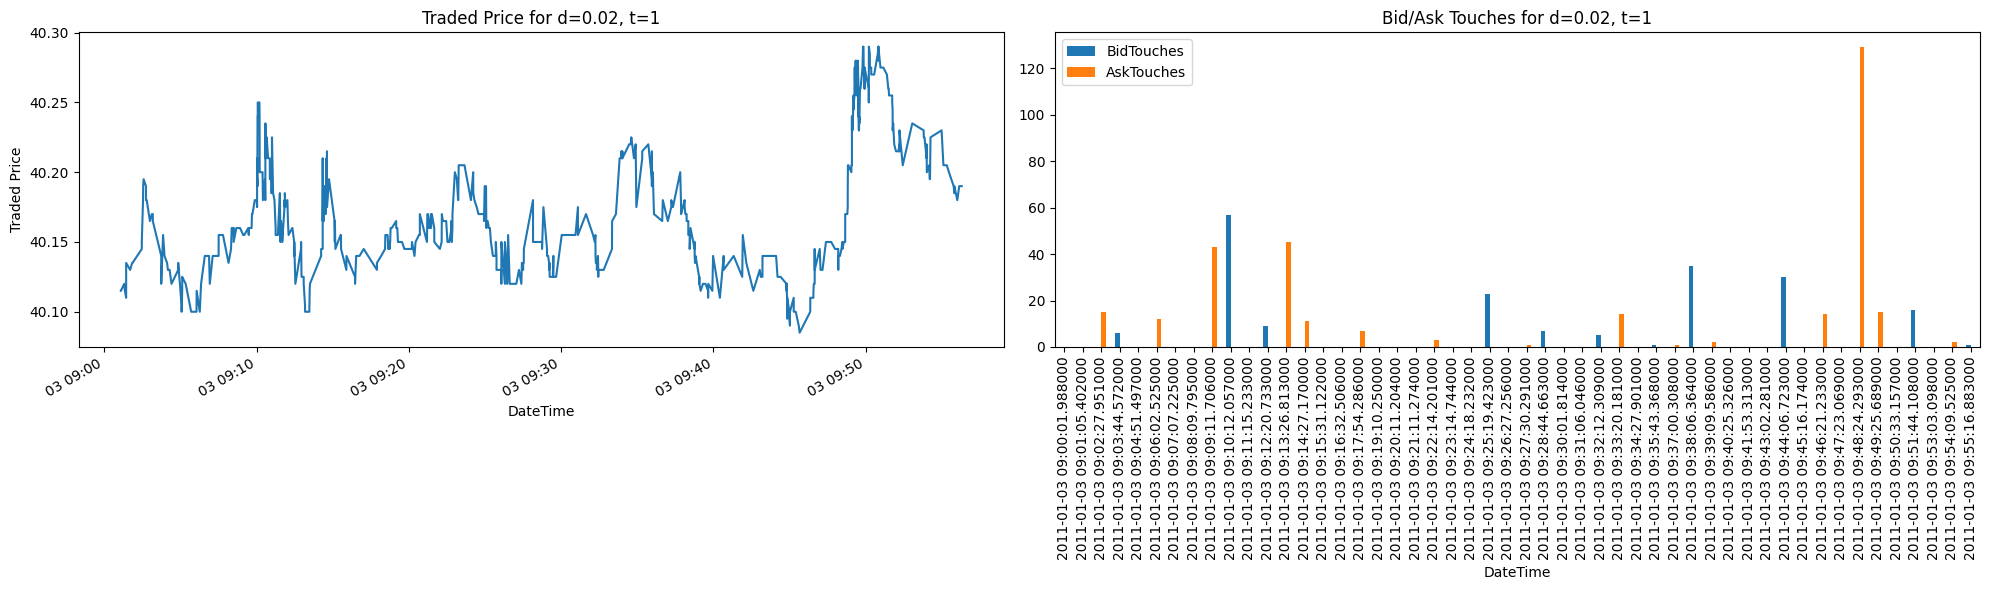

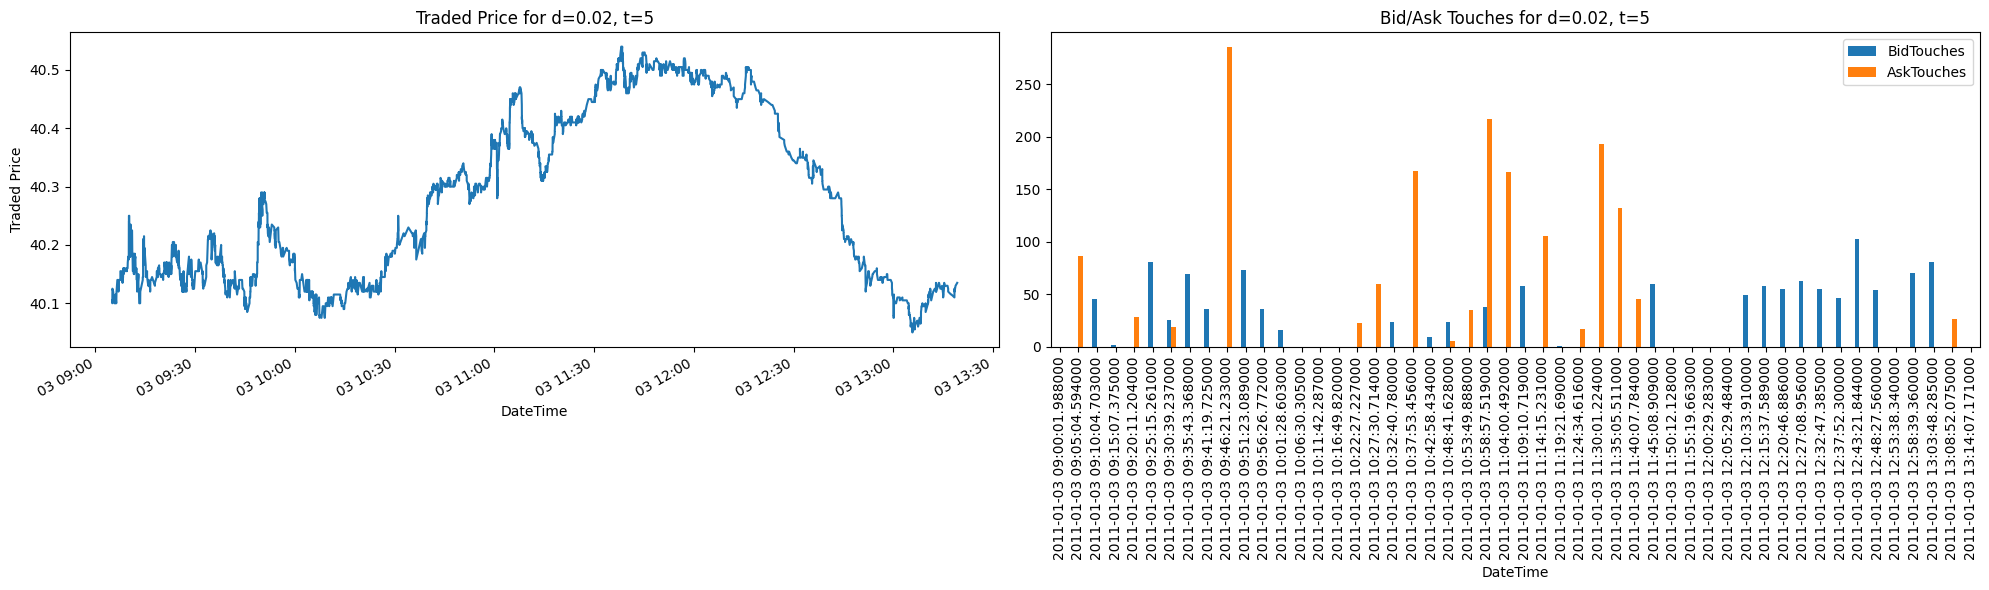

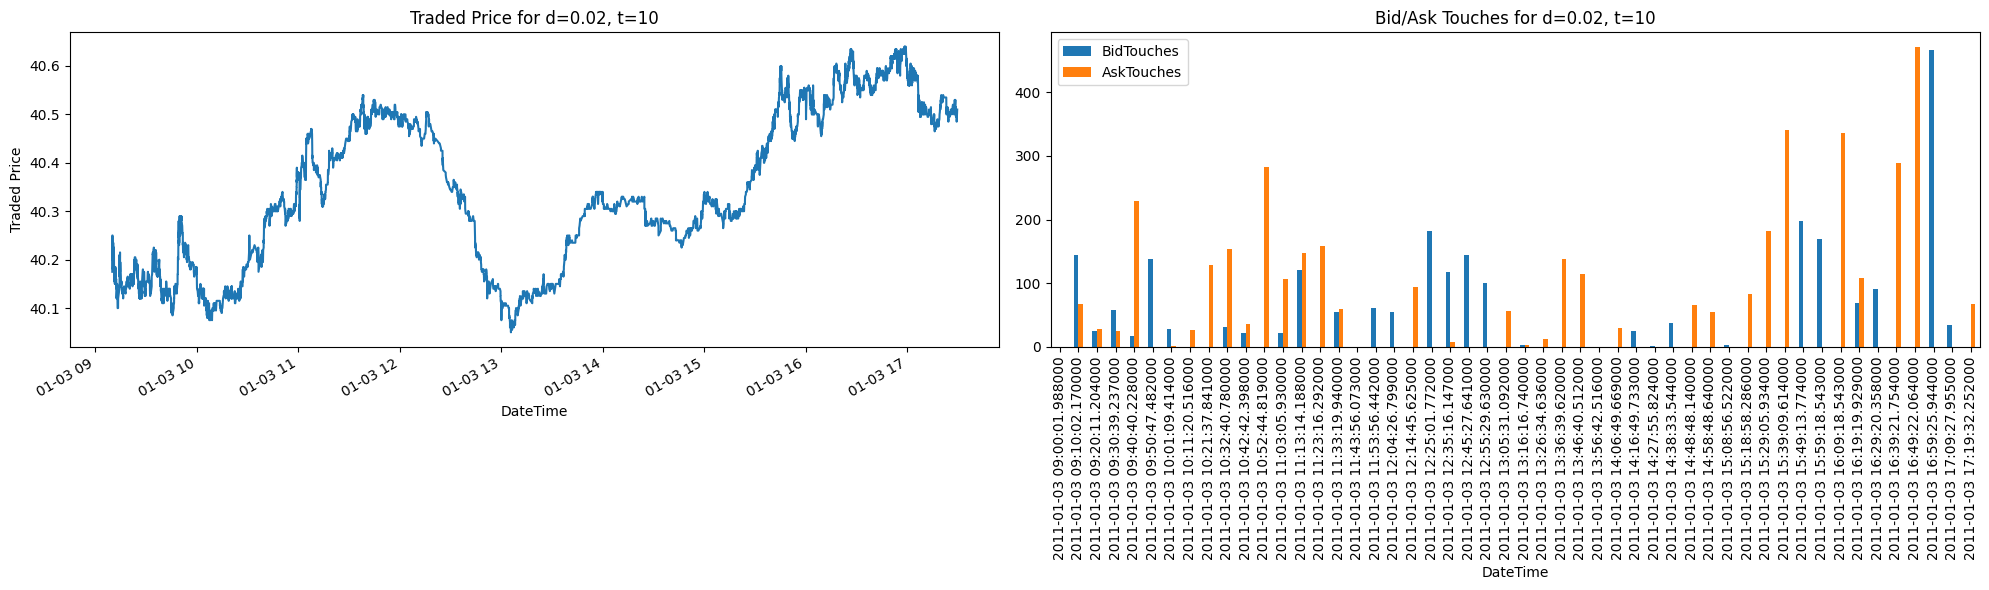

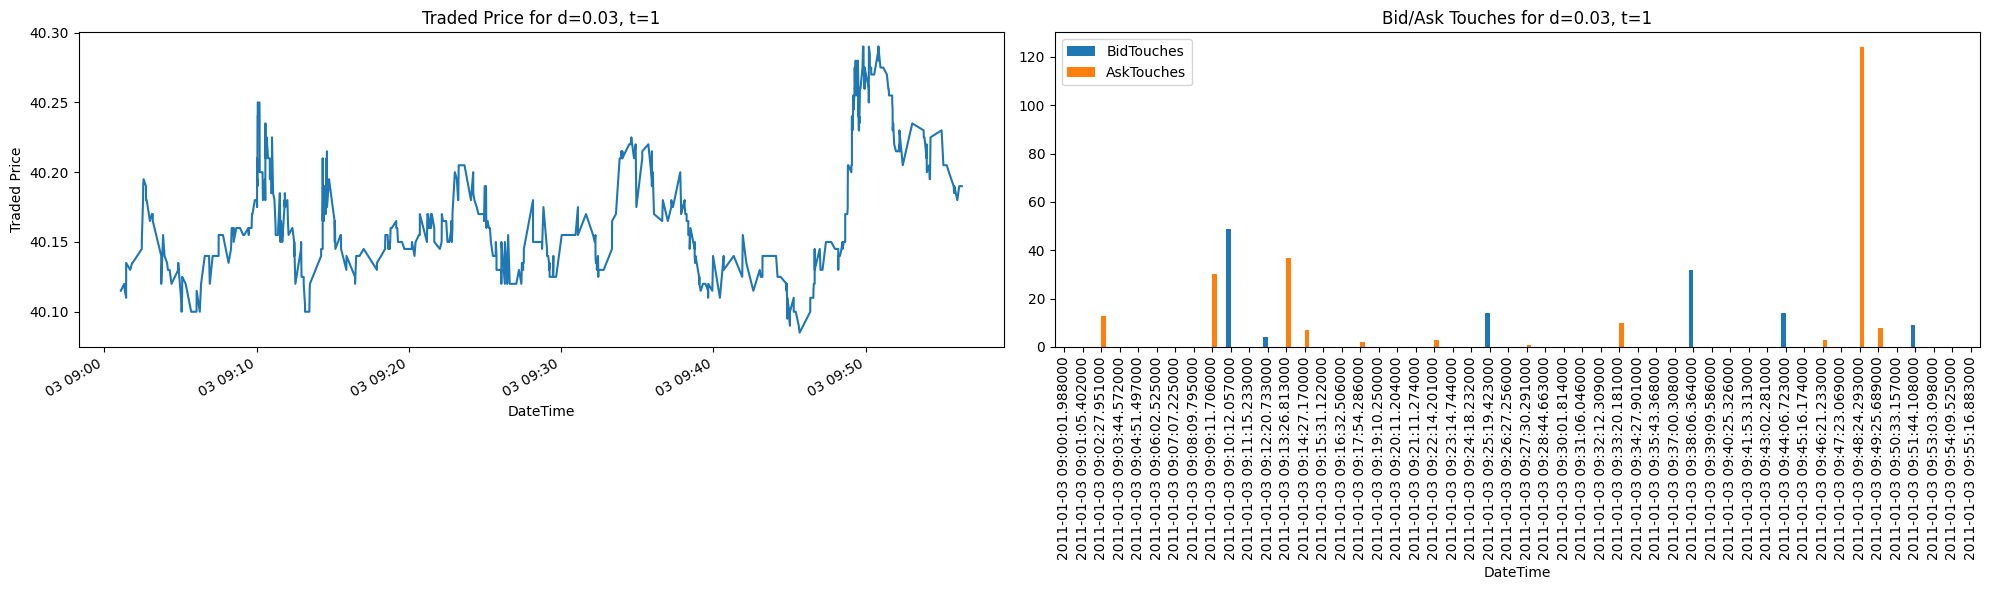

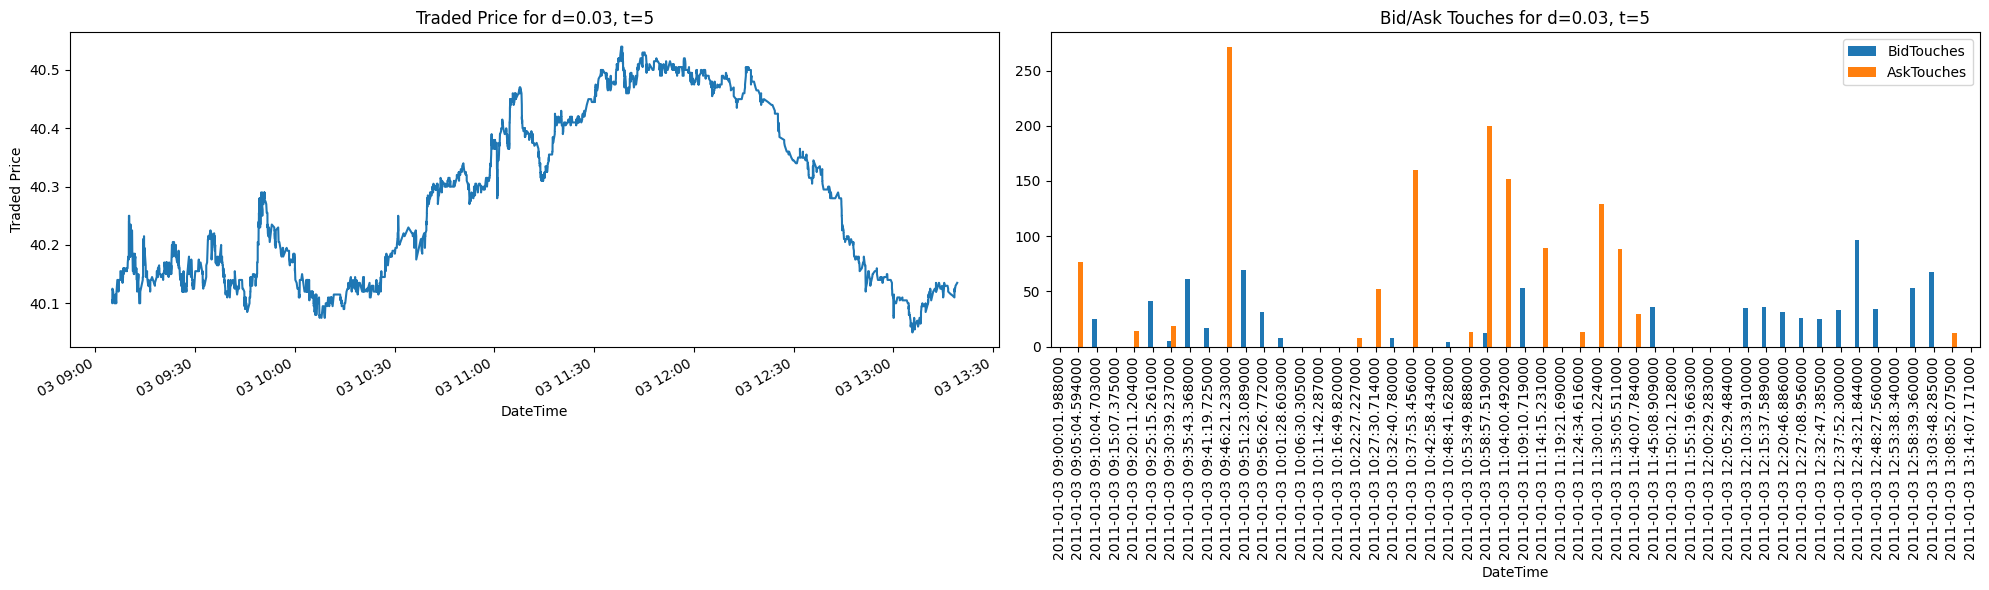

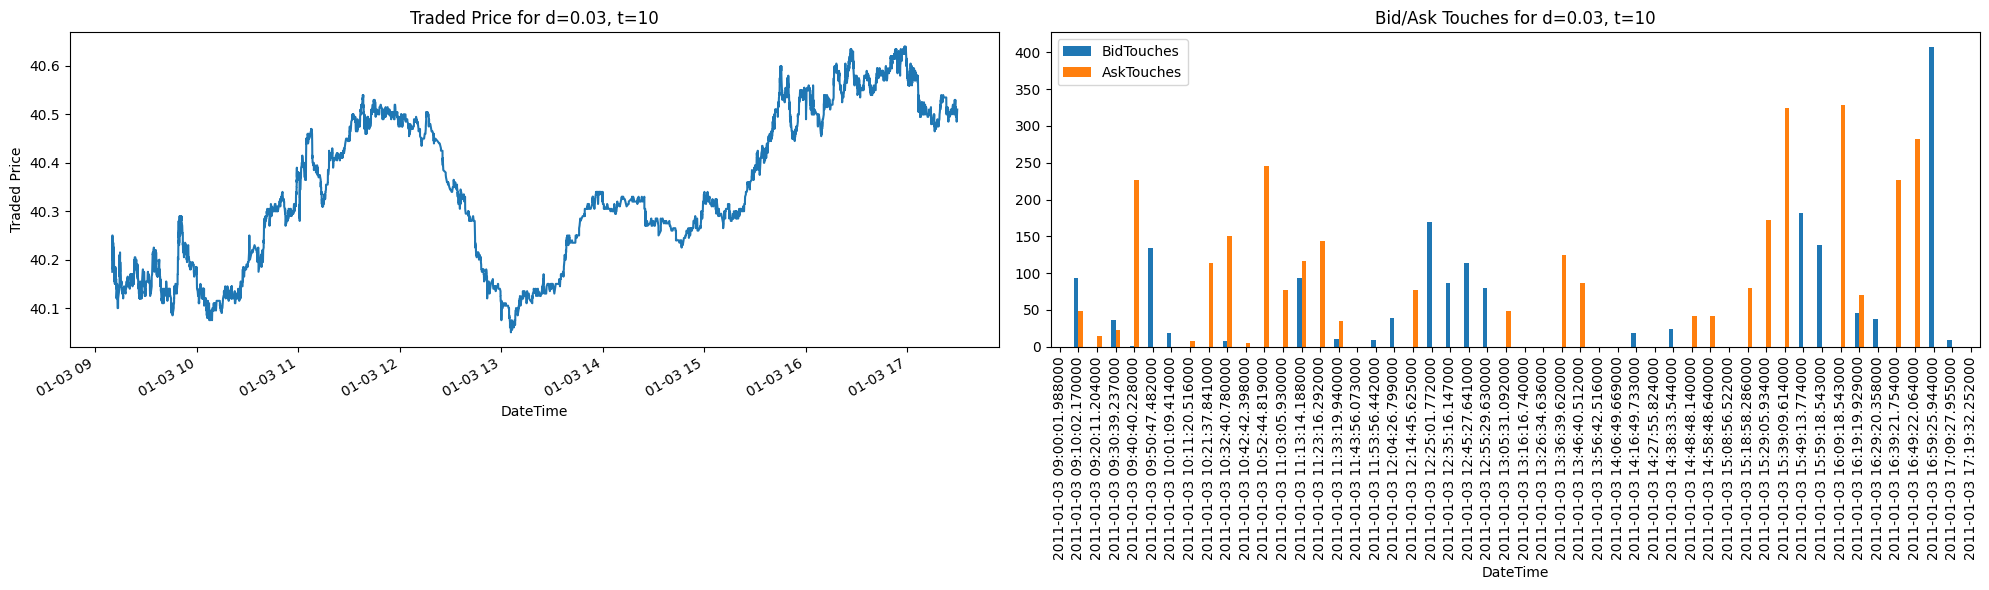

In [68]:
def plot_simulation(df,distance_d, duration_t):
    # Exécution de la simulation
    results_df = simulate_barrier_touch(df,distance_d, duration_t)
    
    # Paramètres de plot
    stop = 50
    
    # Premier graphique : Prix échangés
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    df.loc[results_df.iloc[1]["DateTime"]:results_df.iloc[stop]["DateTime"]]["TradedPrice"].plot(figsize=(10, 6))
    plt.title(f'Traded Price for d={distance_d}, t={duration_t}')
    plt.xlabel('DateTime')
    plt.ylabel('Traded Price')
    
    # Deuxième graphique : Barres de touches Bid/Ask
    plt.subplot(1, 2, 2)
    results_df.iloc[:stop,:].plot(x='DateTime', y=['BidTouches', 'AskTouches'], kind='bar', figsize=(20, 6), ax=plt.gca())
    plt.title(f'Bid/Ask Touches for d={distance_d}, t={duration_t}')
    
    plt.tight_layout()
    plt.show()

# Valeurs de d et t à tester
d_values = [0, 0.01, 0.02, 0.03]
t_values = [1, 5, 10]

# Boucle d'automatisation
for d in d_values:
    for t in t_values:
        plot_simulation(df_total,d, t)

On peut faire plusieurs remarques. Tout d'abord, on note que plus au augmente la durée t, plus on va avoir un grand nombre de fois la barrière touchée, ce qui est logique. Plus on diminue la distance d, plus on observe que la barrière est touchée. 


### 2. Inventory and Market Making

#### a) Inventory

On achète et on vend 1 unité à chaque fois. Donc il s'agit juste de compter le nombre total de fois où l'on touche le bid/l'ask sur une journée. On fait cela pour différents couples (t,d) et on affiche le résultat final. 

In [69]:
def return_nb_fois_touches(df,d,t):
    out = simulate_barrier_touch(df,d, t)
    return out[["BidTouches","AskTouches"]].cumsum().iloc[-1,:].sum()

return_nb_fois_touches(df_total,0,2)

11210

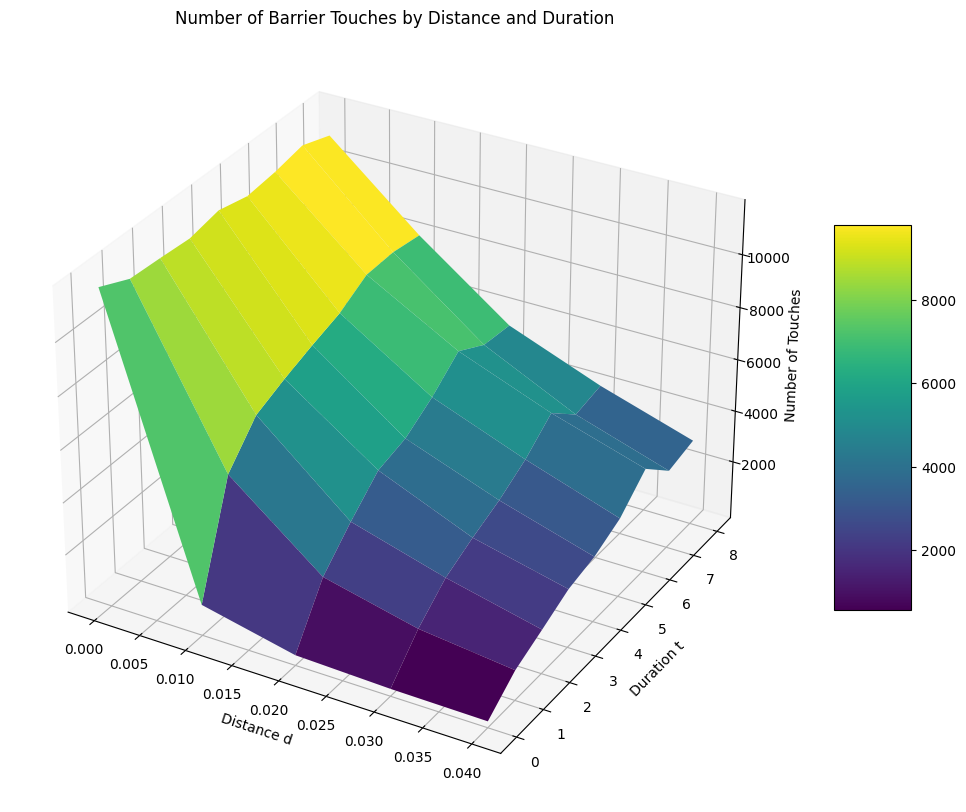

In [70]:
# Initialisation des paramètres
d_values = np.arange(0, 0.05, 0.01)  # de 0 à 1 inclus, avec un pas de 0.01
t_values = np.arange(0, 9)  # de 0 à 15 inclus

# Préparation du tableau de résultats
results = np.zeros((len(d_values), len(t_values)))

# Exécution de la simulation pour chaque combinaison de d et t
for i, d in enumerate(d_values):
    for j, t in enumerate(t_values):
        results[i, j] = return_nb_fois_touches(df_total, d, t)

# Création du graphique 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

D, T = np.meshgrid(d_values, t_values)  # Grilles pour d et t
Z = results.T  # Transpose pour correspondre aux grilles D et T

# Tracé de la surface
surf = ax.plot_surface(D, T, Z, cmap='viridis')

# Personnalisation du graphique
ax.set_xlabel('Distance d')
ax.set_ylabel('Duration t')
ax.set_zlabel('Number of Touches')
ax.set_title('Number of Barrier Touches by Distance and Duration')

# Ajout de la barre de couleur pour la surface
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

On retrouve les résultats que nous avions observés plus tôt. Le volume total diminue d'autant plus que la distance augmente. La duration fait aussi diminuer le volume global lorsque t augmente. 

In [71]:
df_total = import_data('../Stock data/TOTAL.h5', '2011-01-03', 20)
df_total["MidPrice"] = 0.5 * (df_total["BidPrice"] + df_total["AskPrice"])
df_total["Spread"]= df_total["AskPrice"] - df_total["BidPrice"]
ohlc1 = df_total["MidPrice"].resample("D").ohlc().dropna()
VolGK1 = np.sqrt( 0.5 * (ohlc1['high']-ohlc1['low'])**2 - (2*np.log(2)-1) * (ohlc1['close'] - ohlc1['open'])**2 ) # y a une erreur quelque part

mean_spread = df_total["Spread"].resample("D").mean().dropna() #on prend le spread moyen pour chaque jour 

VolGK1 #on a la volatilité en fonction des différents jours du 03 au 21 : vol GK 
mean_spread
df = pd.DataFrame(mean_spread)
df["vol"] = VolGK1.values

In [72]:
#reste à calculer le volume total pr chaque jour 
out = simulate_barrier_touch(df_total,0.01, 1)
out.set_index("DateTime", inplace = True)
out = out[["BidTouches","AskTouches"]].sum(axis=1)
out = out.resample("D").sum()
df["volumes"] = out[out>0].values

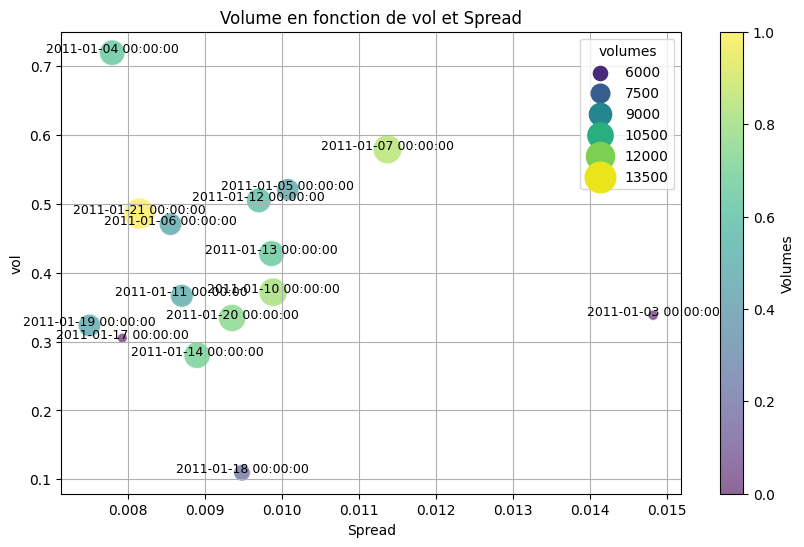

In [73]:
# Utiliser Seaborn pour tracer
plt.figure(figsize=(10, 6))
scatterplot = sns.scatterplot(x='Spread', y='vol', size='volumes', data=df, sizes=(50, 500), hue='volumes', palette='viridis', alpha=0.6)

plt.xlabel('Spread')
plt.ylabel('vol')
plt.title('Volume en fonction de vol et Spread')

# Ajouter des annotations pour quelques points
for i in range(len(df)):
    plt.text(df['Spread'][i], df['vol'][i], df.index[i], fontsize=9, ha='center')

plt.grid(True)

# Obtenir l'objet mappable à partir du scatterplot
mappable = scatterplot.get_children()[0]

# Créer une barre de couleur basée sur l'objet mappable
plt.colorbar(mappable, label='Volumes')

plt.show()

On voit que plus la volatilité est élevée, plus on va avoir des volumes échangés qui sont importants dans la journée. De même, si le spread est trop grand, on a moins de volumes. Il faut donc un spread petit et une volatilité élevée. 

#### b) Static Market Making

In [74]:
def static_simulate_barrier_touch(df, da,db, t):
    """
    Simule le placement de barrières et enregistre chaque fois qu'elles sont touchées.
    
    :param df: DataFrame contenant les données de marché, indexé par DateTime.
    :param d: distance en ticks pour ajuster les barrières du bid et de l'ask.
    :param t: intervalle de temps en minutes pour réajuster les barrières.
    :return: DataFrame des résultats avec la date de mise en place, et le nombre de touches pour chaque barrière.
    """
    results = []
    last_update_time = df.index[0] - pd.Timedelta(minutes=t)  # Pour s'assurer de mettre à jour au premier pas
    nb_actions= 0
    inventary = []
    
    # Initialisation des compteurs de touches
    bid_touches, ask_touches = 0, 0

    for current_time, row in df.iterrows():
        # Mise à jour des barrières tous les t minutes
        if (current_time - last_update_time) >= pd.Timedelta(minutes=t):
            if last_update_time != df.index[0] - pd.Timedelta(minutes=t):
                # Enregistrement des résultats de la période précédente
                results.append({'DateTime': last_update_time, 'BidTouches': bid_touches, 'AskTouches': ask_touches, 'spread': ask_barrier - bid_barrier -2*d})
            
            # Réinitialisation des compteurs de touches
            bid_touches, ask_touches = 0, 0
            last_update_time = current_time
            
            # Mise à jour des barrières
            bid_barrier = row['BidPrice'] - db
            ask_barrier = row['AskPrice'] + da
        
        # Vérification si les barrières sont touchées : à checker 
        if row['TradedPrice'] <= bid_barrier:
            bid_touches += 1
            nb_actions-=1
            inventary.append(nb_actions)
        if row['TradedPrice'] >= ask_barrier:
            ask_touches += 1
            nb_actions+=1
            inventary.append(nb_actions)
    
    # Enregistrement des résultats de la dernière période
    results.append({'DateTime': last_update_time, 'BidTouches': bid_touches, 'AskTouches': ask_touches, 'spread': ask_barrier - bid_barrier -2*d})
    
    return pd.DataFrame(results),inventary

In [77]:
best_da = None
best_db = None
best_diff = float('inf')

# Plage de valeurs pour da et db
da_range = [0.001 * i for i in range(1, 10)]
db_range = [0.001 * i for i in range(1, 10)]

# Itération sur toutes les combinaisons de da et db
for da in da_range:
    for db in db_range:
        out, inventaire = static_simulate_barrier_touch(df_total, da, db, 10)
        diff = abs(inventaire[-1])
        if diff < best_diff:
            best_diff = diff
            best_da = da
            best_db = db

print("Meilleur da :", best_da)
print("Meilleur db :", best_db)
print("Inventaire final le plus proche de 0 :", inventaire[-1])

KeyboardInterrupt: 

Lorsque l'on est sur t=1 minutes, on trouve que l'optimal est :

- Meilleur da : 0.005
- Meilleur db : 0.006
- Inventaire final le plus proche de 0 : -862

Lorsque l'on est sur t=5 minutes, on trouve que l'optimal est :

- Meilleur da : 0.001
- Meilleur db : 0.005
- Inventaire final le plus proche de 0 : -182

Lorsque l'on est sur t=10 minutes, on trouve que l'optimal est :

- Meilleur da : 0.001
- Meilleur db : 0.006
- Inventaire final le plus proche de 0 : -1931

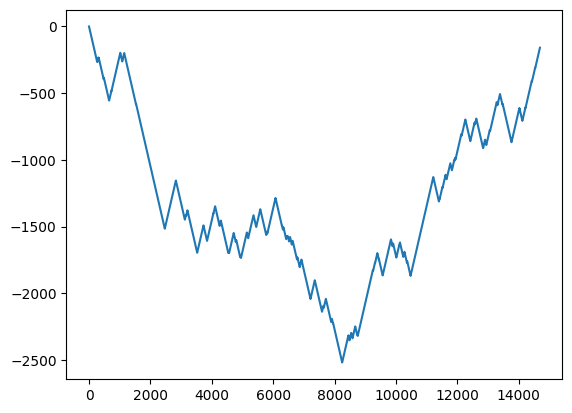

In [78]:
df_total = import_data('../Stock Data/TOTAL.h5', '2011-01-05', 1) # on se place au 04/01/2011 par exemple
out, inventaire = static_simulate_barrier_touch(df_total,0.001,0.005,5)
plt.plot(inventaire) # on voit ici une évolution possible de l'invenatire
plt.show()

On choisit par exemple de fixer ici que t = 5 minutes, pour rester en adéquation avec le graphique précédent. On voit que pour le 05 janvier 2011, la volatilité chez total était de 0.520624. On en déduit que : 

In [79]:
cb = 0.005/0.520624
ca = 0.001/0.520624

print("le meilleur cb est "+ str(cb) +" le meilleur ca est "+str(ca))

le meilleur cb est 0.00960385998340453 le meilleur ca est 0.0019207719966809061


#### c) P&L Implementation

Calcul du P&L. On plot différents P&L pour des da, db différents. Comme fonctions de la volatilité. 

In [80]:
output = pd.DataFrame()
i=0
for item, row in df.iterrows():

    df_total_ = import_data('../Stock Data/TOTAL.h5', item, 1) 
    out, inventaire = static_simulate_barrier_touch(df_total_,ca*row["vol"],cb*row["vol"],5)
    output.loc[i,"inventory"]= inventaire[-1]
    output.loc[i,"price"]= (df_total_.iloc[-1,:]["BidPrice"] + df_total_.iloc[-1,:]["AskPrice"])/2
    output.loc[i,"PNL"]= inventaire[-1]*(df_total_.iloc[-1,:]["BidPrice"] + df_total_.iloc[-1,:]["AskPrice"])/2  # le résultat P&L
    output.loc[i,"Spread"]= row["Spread"]
    output.loc[i,"vol"]= row["vol"]
    i+=1

output

,inventory,price,PNL,Spread,vol
0,1619.0,40.5025,65573.5475,0.014822,0.338276
1,3367.0,41.1250,138467.8750,0.007796,0.719425
2,813.0,41.1950,33491.5350,0.010077,0.520624
3,-546.0,41.5450,-22683.5700,0.008553,0.470550
4,-320.0,41.2225,-13191.2000,0.011371,0.579194
5,-609.0,40.7700,-24828.9300,0.009886,0.371732
6,2480.0,41.0575,101822.6000,0.008700,0.366467
7,1939.0,41.7625,80977.4875,0.009700,0.505078
8,1539.0,41.9900,64622.6100,0.009866,0.427805
9,3510.0,42.4550,149017.0500,0.008898,0.280237


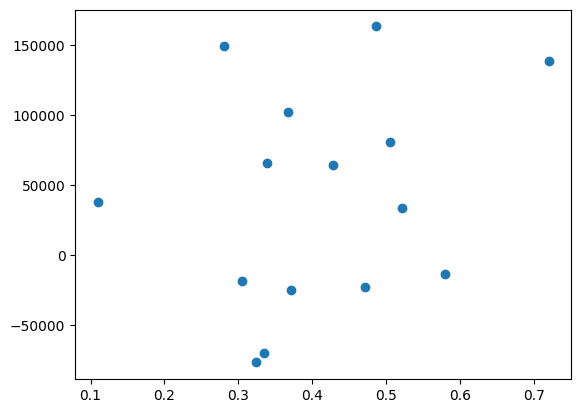

In [81]:
plt.scatter(output["vol"].values, output["PNL"].values)
plt.show()

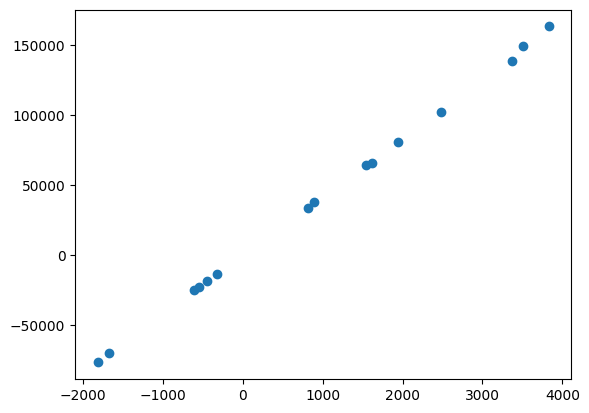

In [82]:
plt.scatter(output["inventory"].values, output["PNL"].values) # c'est quasi linéaire 
plt.show()

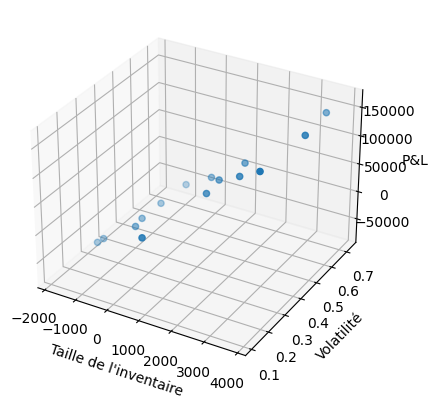

In [83]:
# Exemple de données
X = output["inventory"].values
Y = output["vol"].values
Z = output["PNL"].values

# Création d'une figure et d'un axe 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracé des données. Ici, vous pouvez utiliser scatter pour des points ou plot pour une ligne.
ax.scatter(X, Y, Z)

# Titres et labels
ax.set_xlabel('Taille de l\'inventaire')
ax.set_ylabel('Volatilité')
ax.set_zlabel('P&L')

plt.show()

Comme on ajuste da et db en fonction de la volatilité, on n'a pas visuellement l'impression que la volatilité impact le P&L. F devrait ressembler à un hyperplan affine que l'on aurait déformé sur les bords. 